<a href="https://colab.research.google.com/github/Mano1498/Customer_Segmentation_Project/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Dataset Link(UCI ML Repo) : https://archive.ics.uci.edu/dataset/352/online+RFM1

In [5]:
data = pd.read_excel("/content/drive/MyDrive/DataSets/Online Retail.xlsx")

In [6]:
df = data.copy()

In [7]:
df.shape

(541909, 8)

In [8]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [9]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

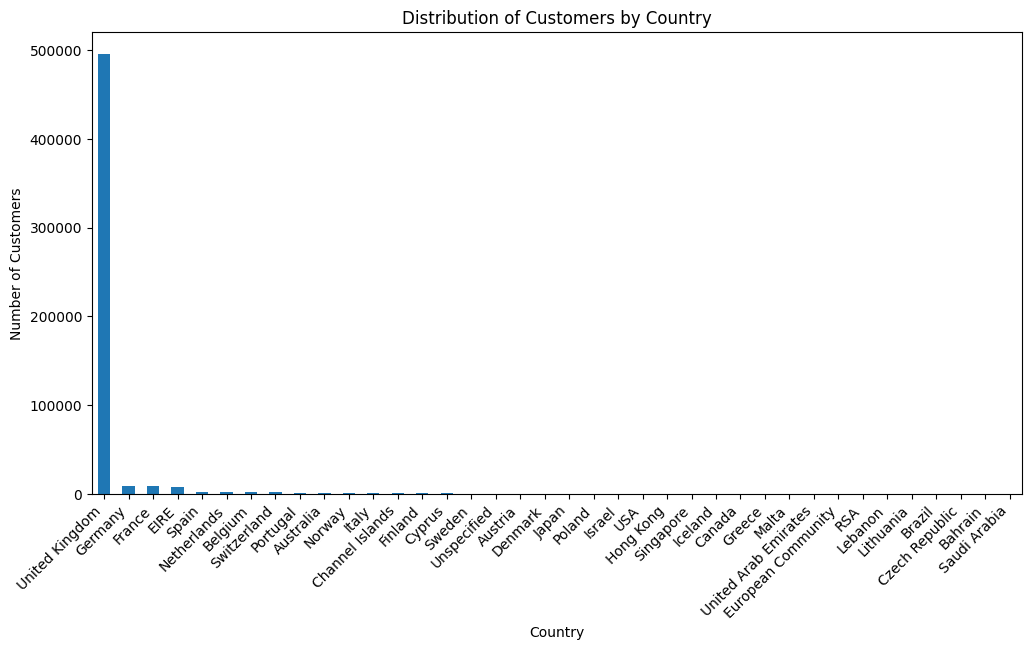

In [11]:
# Distribution of Customer by Country
country_counts = data['Country'].value_counts()
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers by Country')
plt.xticks(rotation=45, ha='right') # ha - horizonatal alingment
plt.show()

In [12]:
df["CustomerID"].nunique()

4372

In [13]:
country_wise_dis = df[["Country","CustomerID"]].drop_duplicates()
result = country_wise_dis.groupby(["Country"])["CustomerID"].aggregate("count").reset_index().sort_values("CustomerID",ascending=False)
result.head()

Country  CustomerID
36  United Kingdom        3950
14         Germany          95
13          France          87
31           Spain          31
3          Belgium          25

In [14]:
df = df[df['Country'] == 'United Kingdom'].reset_index(drop=True) #  keeping only united Kingdom data

In [15]:
df = df.dropna(subset=['CustomerID'])
df = df.reset_index(drop=True)

In [16]:
# Filtering negative values
df = df[(df['Quantity']>0)]
df = df[(df['UnitPrice']>0)]

In [17]:
df["TotalAmount"] = df['Quantity']*df['UnitPrice'] # Creating Total amount column

In [18]:
df.shape

(354321, 9)

In [19]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34

## Calculating R,F,M values

In [20]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [21]:
rfm_a = df.groupby("CustomerID")["TotalAmount"].sum()
rfm_a = rfm_a.reset_index()
rfm_a.columns = ["CustomerID","Monetary"]

In [22]:
rfm_a['Monetary'] = rfm_a['Monetary'].round().astype(int)

In [23]:
rfm_a.head()

CustomerID  Monetary
0       12346     77184
1       12747      4196
2       12748     33720
3       12749      4091
4       12820       942

In [24]:
rfm_f = df.groupby("CustomerID")["InvoiceNo"].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ["CustomerID","Frequency"]

In [25]:
rfm_f.head()

CustomerID  Frequency
0       12346          1
1       12747        103
2       12748       4595
3       12749        199
4       12820         59

In [26]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
current_date = df['InvoiceDate'].max()

In [27]:
current_date

Timestamp('2011-12-09 12:49:00')

In [28]:
rfm_r = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
rfm_r.columns = ['CustomerID', 'LastPurchaseDate']

In [29]:
rfm_r['Recency'] = (current_date - rfm_r['LastPurchaseDate']).dt.days # extract the number of days from a pandas Timestamp

In [30]:
rfm_r.head()

CustomerID    LastPurchaseDate  Recency
0       12346 2011-01-18 10:01:00      325
1       12747 2011-12-07 14:34:00        1
2       12748 2011-12-09 12:20:00        0
3       12749 2011-12-06 09:56:00        3
4       12820 2011-12-06 15:12:00        2

In [31]:
rfm_r = rfm_r.drop('LastPurchaseDate', axis=1)

In [32]:
rfm_r.head()

CustomerID  Recency
0       12346      325
1       12747        1
2       12748        0
3       12749        3
4       12820        2

In [33]:
RFM = pd.merge(rfm_r ,rfm_f , on="CustomerID",how="inner") # Joins rows with matching values
RFM.head()

CustomerID  Recency  Frequency
0       12346      325          1
1       12747        1        103
2       12748        0       4595
3       12749        3        199
4       12820        2         59

In [34]:
RFM = pd.merge(RFM ,rfm_a , on="CustomerID",how="inner")
RFM.head()

CustomerID  Recency  Frequency  Monetary
0       12346      325          1     77184
1       12747        1        103      4196
2       12748        0       4595     33720
3       12749        3        199      4091
4       12820        2         59       942

In [35]:
RFM.shape

(3920, 4)

## Outliers Detection and Removal

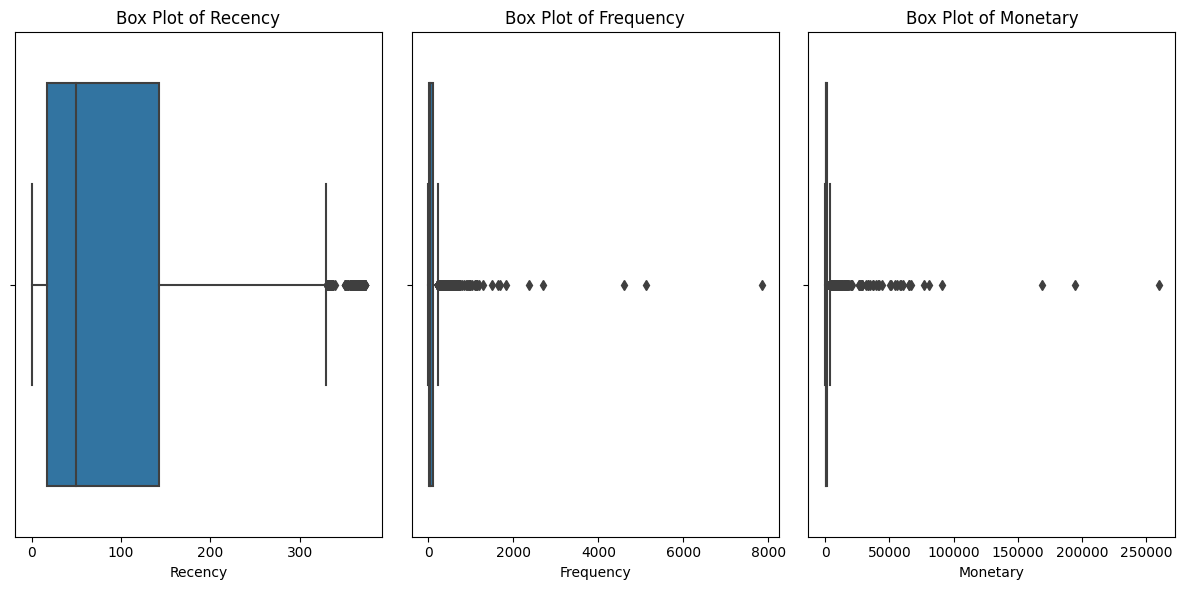

In [36]:
plt.figure(figsize=(12, 6)) # 12 inches in width and 6 inches in height

# Box plot for Recency
plt.subplot(1, 3, 1)                                      # Creating subplots with 1 row and 3 columns
sns.boxplot(x='Recency', data=RFM, orient='v')            # Box plot in Vertical Orientation
plt.title('Box Plot of Recency')

# Box plot for Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Frequency', data=RFM, orient='v')
plt.title('Box Plot of Frequency')

# Box plot for Monetary
plt.subplot(1, 3, 3)
sns.boxplot(x='Monetary', data=RFM, orient='v')
plt.title('Box Plot of Monetary')

# Adjust the layout
plt.tight_layout()

# Show the box plots
plt.show()

In [37]:
# Function to remove Outliers Using IQR Method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
columns_to_remove_outliers = ['Recency', 'Frequency', 'Monetary']
RFM1= remove_outliers(RFM, columns_to_remove_outliers)

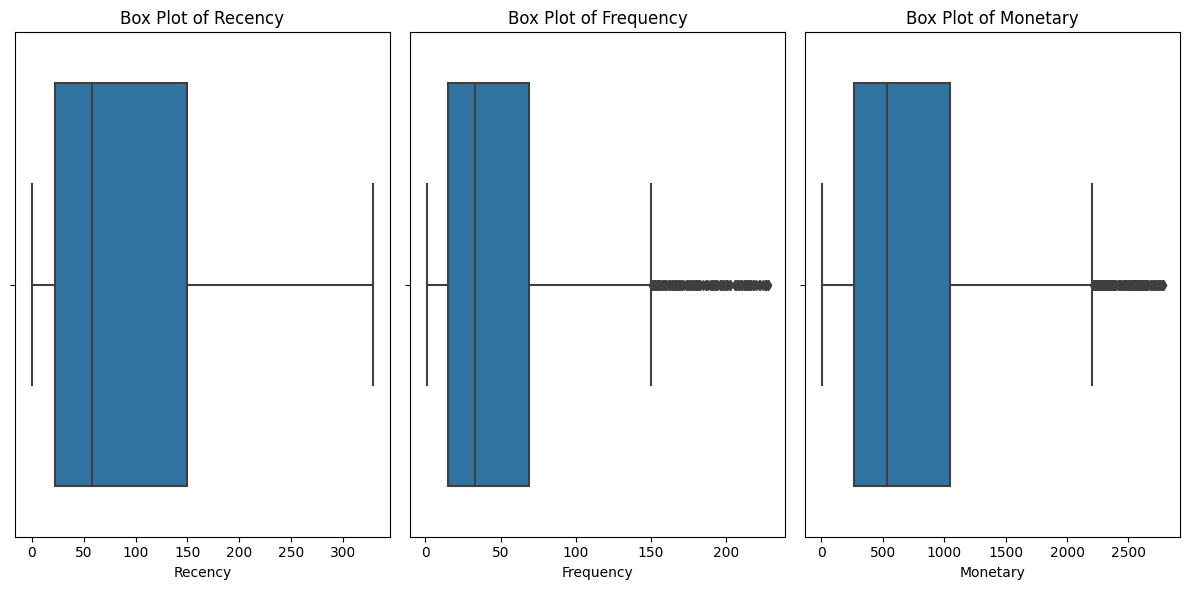

In [38]:
plt.figure(figsize=(12, 6))

# Box plot for Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='Recency', data=RFM1, orient='v')
plt.title('Box Plot of Recency')

# Box plot for Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Frequency', data=RFM1, orient='v')
plt.title('Box Plot of Frequency')

# Box plot for Monetary
plt.subplot(1, 3, 3)
sns.boxplot(x='Monetary', data=RFM1, orient='v')
plt.title('Box Plot of Monetary')

# Adjust the layout
plt.tight_layout()

# Show the box plots
plt.show()

In [39]:
RFM1.Recency.describe()

count    3179.000000
mean       92.512425
std        89.960711
min         0.000000
25%        22.000000
50%        58.000000
75%       149.500000
max       329.000000
Name: Recency, dtype: float64

In [40]:
RFM1.Frequency.describe()

count    3179.000000
mean       48.878893
std        45.965012
min         1.000000
25%        15.000000
50%        33.000000
75%        69.000000
max       228.000000
Name: Frequency, dtype: float64

In [41]:
RFM1.Monetary.describe()

count    3179.000000
mean      742.894306
std       634.685894
min         4.000000
25%       267.000000
50%       530.000000
75%      1043.000000
max      2781.000000
Name: Monetary, dtype: float64

## Calculating RFM Scores

In [42]:
#Split into four segments using quantiles
quantiles = RFM1.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [43]:
quantiles

{'CustomerID': {0.25: 14200.0, 0.5: 15571.0, 0.75: 16922.5},
 'Recency': {0.25: 22.0, 0.5: 58.0, 0.75: 149.5},
 'Frequency': {0.25: 15.0, 0.5: 33.0, 0.75: 69.0},
 'Monetary': {0.25: 267.0, 0.5: 530.0, 0.75: 1043.0}}

In [44]:
quantiles.keys()

dict_keys(['CustomerID', 'Recency', 'Frequency', 'Monetary'])

In [45]:
#Functions to create R, F and M segments
def RScoring(x,p,d):                   # d = quantiles dict , p = quantiles keys , x = Recency value
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FnMScoring(x,p,d):                 # d = quantiles dict , p = quantiles keys , x = Frequency and Monetary values
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [46]:
RFM1['R-Score'] = RFM1['Recency'].apply(RScoring, args=('Recency',quantiles))
RFM1['F-Score'] = RFM1['Frequency'].apply(FnMScoring, args=('Frequency',quantiles))
RFM1['M-Score'] = RFM1['Monetary'].apply(FnMScoring, args=('Monetary',quantiles))
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score
4       12820        2         59       942        1        2        2
5       12821      213          6        93        4        4        4
6       12822       70         46       949        3        2        2
7       12823       74          5      1760        3        4        1
8       12824       59         25       397        3        3        3

In [47]:
RFM1['RFMScore'] = RFM1['R-Score'] + RFM1['F-Score'] + RFM1['M-Score']

In [48]:
RFM1.shape

(3179, 8)

In [49]:
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score  \
4       12820        2         59       942        1        2        2   
5       12821      213          6        93        4        4        4   
6       12822       70         46       949        3        2        2   
7       12823       74          5      1760        3        4        1   
8       12824       59         25       397        3        3        3   

   RFMScore  
4         5  
5        12  
6         7  
7         8  
8         9

## Assigning Loyalty Levels Based on RFM Scores

In [50]:
# function to assign loyalty levels based on 'RFM1Score'
def LoyaltyLevel(row):
    if row['RFMScore'] >= 10:
        return 'Bronze'
    elif row['RFMScore'] >= 8:
        return 'Silver'
    elif row['RFMScore'] >= 6:
        return 'Gold'
    else:
        return 'Platinum'
# Apply the LoyaltyLevel function to DataFrame
RFM1['LoyaltyLevel'] = RFM1.apply(LoyaltyLevel, axis=1)

In [51]:
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score  \
4       12820        2         59       942        1        2        2   
5       12821      213          6        93        4        4        4   
6       12822       70         46       949        3        2        2   
7       12823       74          5      1760        3        4        1   
8       12824       59         25       397        3        3        3   

   RFMScore LoyaltyLevel  
4         5     Platinum  
5        12       Bronze  
6         7         Gold  
7         8       Silver  
8         9       Silver

## Data Visualization

In [124]:
loyalty_colors = {
    'Platinum': '#0065A4',  # Dark Blue
    'Gold': '#FFD700',      # Gold
    'Silver': '#808080',    # Gray
    'Bronze': '#D2691E'     # Chocolate
}

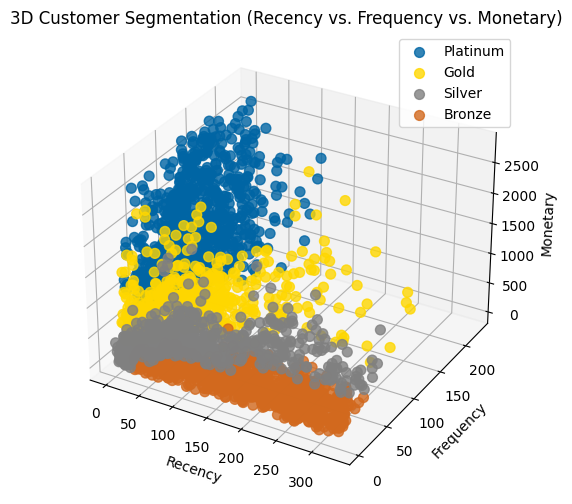

In [125]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')                                                                                   #111 - fig 1row,1column at position 1
for loyalty_level, color in loyalty_colors.items():
    subset = RFM1[RFM1['LoyaltyLevel'] == loyalty_level]                                                                 # label - assigns a label to the data points (for legend)
    ax.scatter(subset['Recency'], subset['Frequency'], subset['Monetary'], c=color, label=loyalty_level, s=50, alpha=0.8)    # s - Size of data points , alpha - transparency
ax.set_xlabel('Recency')                                                                                                     # c - set color of data point
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Customer Segmentation (Recency vs. Frequency vs. Monetary)')
ax.legend()
plt.show()

In [52]:
pip install plotly # For Interactive Plot

about plotly : https://plotly.com/

In [53]:
import plotly.express as px
fig = px.scatter_3d(RFM1, x='Recency', y='Frequency', z='Monetary', color='LoyaltyLevel', hover_name='CustomerID')
fig.update_layout(
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary',
    ),
    title='3D Customer Segmentation (Recency vs. Frequency vs. Monetary)'
)
fig.show()

## Displaying Image of Interactive Plot for Github

Saving Interactive Plot.png to Interactive Plot.png


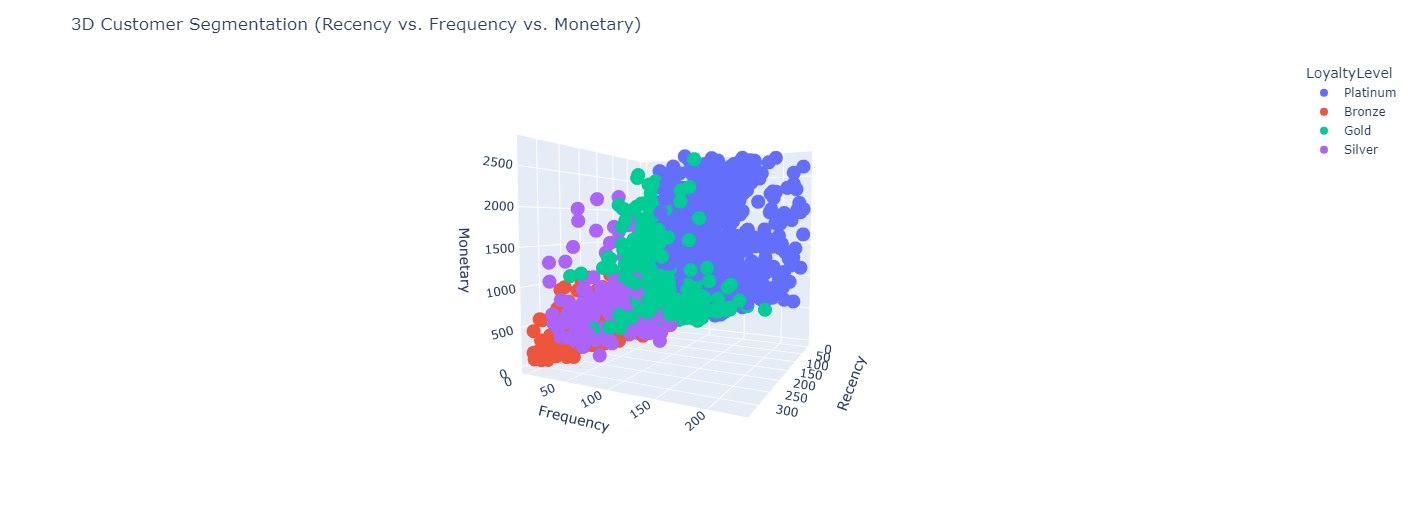

In [54]:
from google.colab import files
from IPython.display import Image
Uploaded = files.upload()
Image("Interactive Plot.png")

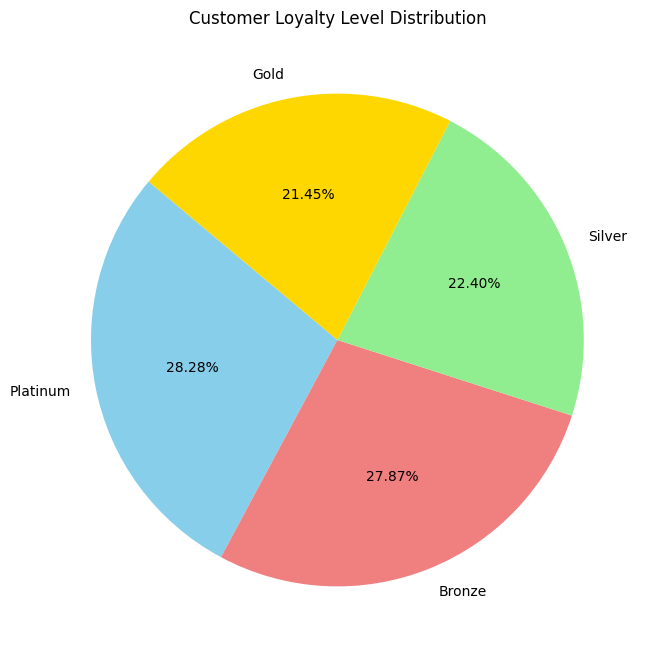

In [55]:
# Count the number of customers in each loyalty level
loyalty_counts = RFM1['LoyaltyLevel'].value_counts()
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(loyalty_counts, labels=loyalty_counts.index, autopct='%1.2f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Customer Loyalty Level Distribution')
plt.show()

## RFM Segmented Customer Information

In [56]:
features = ["Recency","Frequency","Monetary"]
data = RFM1[features].copy()
data = data.reset_index(drop=True)

In [57]:
data.head()

Recency  Frequency  Monetary
0        2         59       942
1      213          6        93
2       70         46       949
3       74          5      1760
4       59         25       397

<Axes: xlabel='Recency', ylabel='Count'>

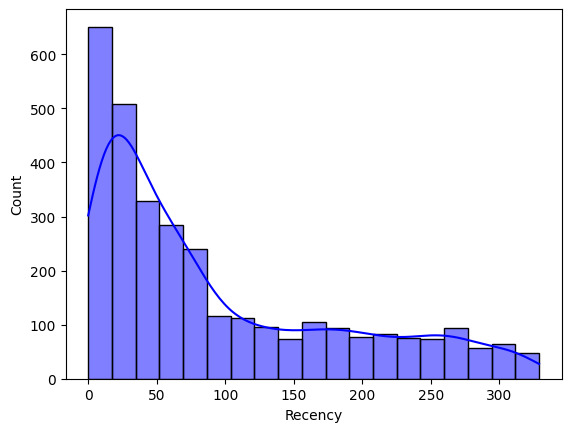

In [58]:
sns.histplot(data.Recency,kde=True,color="blue")

<Axes: xlabel='Frequency', ylabel='Count'>

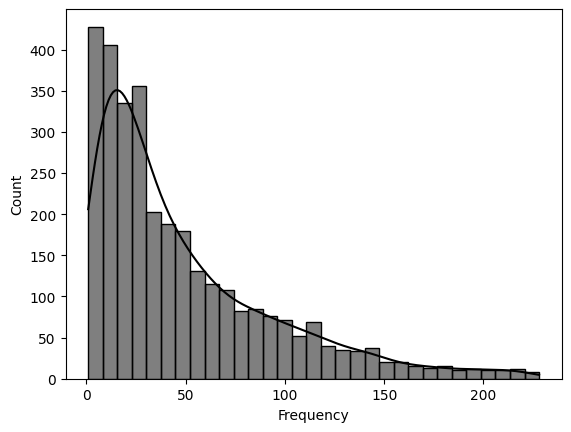

In [59]:
sns.histplot(data.Frequency,kde=True,color="black")

<Axes: xlabel='Monetary', ylabel='Count'>

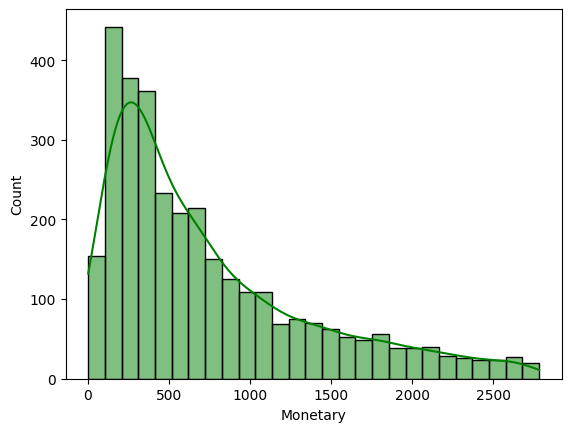

In [60]:
sns.histplot(data.Monetary,kde=True,color="green")

In [61]:
data[["Recency", "Frequency", "Monetary"]].min()

Recency      0
Frequency    1
Monetary     4
dtype: int64

In [62]:
data["Recency"].replace(0,1,inplace=True)

Lambda value : 0.23921326158697623


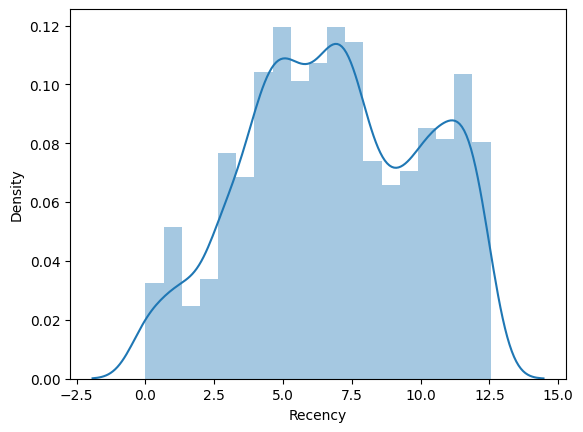

In [63]:
data["Recency"], lam_r = stats.boxcox(data["Recency"])
sns.distplot(data.Recency)
print("Lambda value :",lam_r)

Lambda value : 0.21730579181694484


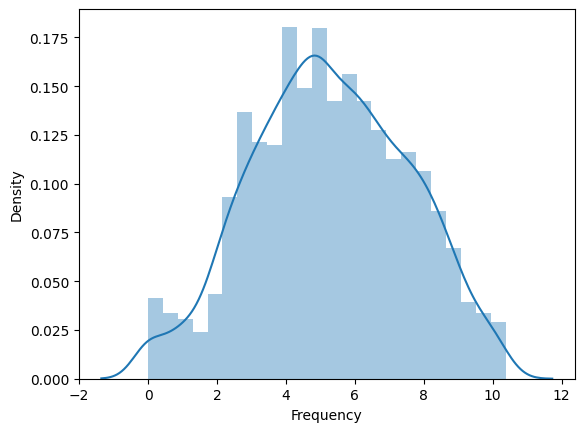

In [64]:


data["Frequency"], lam_f = stats.boxcox(data["Frequency"])
sns.distplot(data.Frequency)
print("Lambda value :",lam_f)

Lambda value : 0.1616362633541601


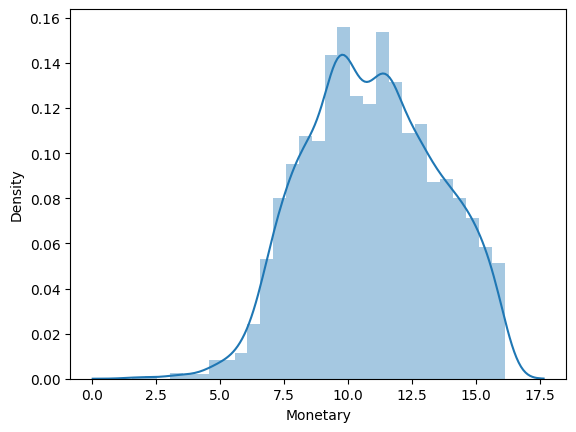

In [65]:
data["Monetary"], lam_m = stats.boxcox(data["Monetary"])
sns.distplot(data.Monetary)
print("Lambda value :",lam_m)

In [66]:
scl = StandardScaler()
c = ["Recency","Frequency","Monetary"]
data[c] = scl.fit_transform(data[c])

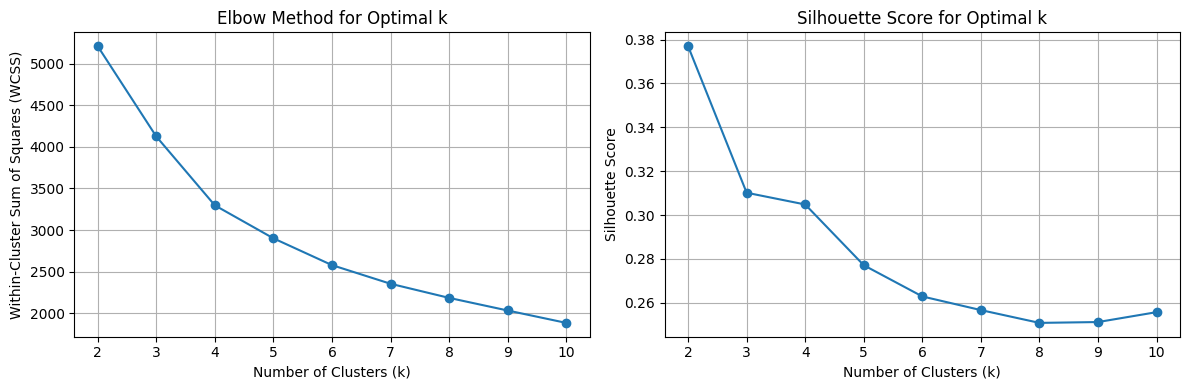

In [67]:
k_values = range(2, 11)

wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

fig, (el, sl) = plt.subplots(1, 2, figsize=(12, 4))    # 1 row and 2 column
# Elbow method plot
el.plot(k_values, wcss, marker='o')
el.set_xlabel('Number of Clusters (k)')
el.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
el.set_title('Elbow Method for Optimal k')
el.grid(True)
# Silhouette score plot
sl.plot(k_values, silhouette_scores, marker='o')
sl.set_xlabel('Number of Clusters (k)')
sl.set_ylabel('Silhouette Score')
sl.set_title('Silhouette Score for Optimal k')
sl.grid(True)

plt.tight_layout()
plt.show()

In [68]:
wcss

[5211.012008532375,
 4125.609481122834,
 3297.5177216099282,
 2901.260170886194,
 2579.019318276971,
 2354.847691517015,
 2185.079508870044,
 2033.4849641293074,
 1884.4820098270989]

In [69]:
silhouette_scores

[0.3769690007541157,
 0.31015176837682695,
 0.3047935054926325,
 0.27710492553349547,
 0.26287469176742906,
 0.25664957988466225,
 0.25081834698691774,
 0.2511999384985961,
 0.2557116003278509]

# Reference for Silhouette Plot

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

For n_clusters = 2, the average silhouette_score is : 0.38
For n_clusters = 3, the average silhouette_score is : 0.31
For n_clusters = 4, the average silhouette_score is : 0.30
For n_clusters = 5, the average silhouette_score is : 0.28
For n_clusters = 6, the average silhouette_score is : 0.26
For n_clusters = 7, the average silhouette_score is : 0.26
For n_clusters = 8, the average silhouette_score is : 0.26
For n_clusters = 9, the average silhouette_score is : 0.26
For n_clusters = 10, the average silhouette_score is : 0.26


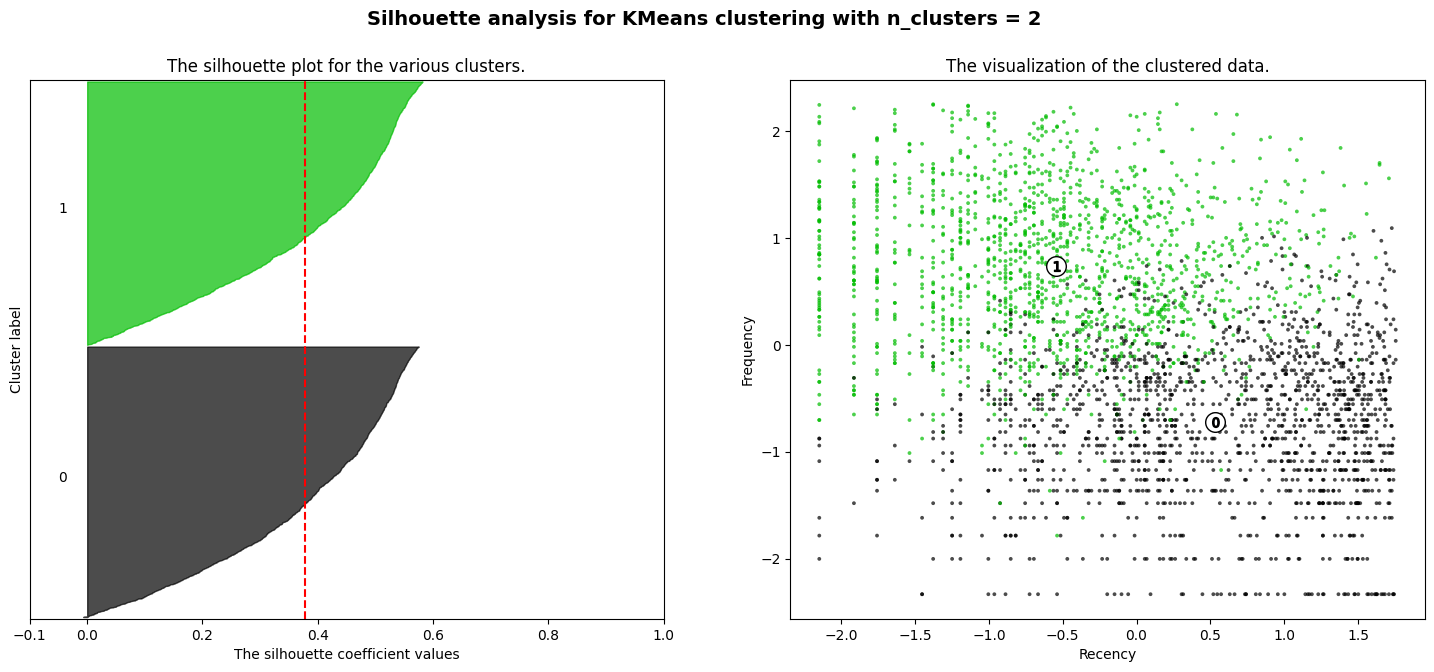

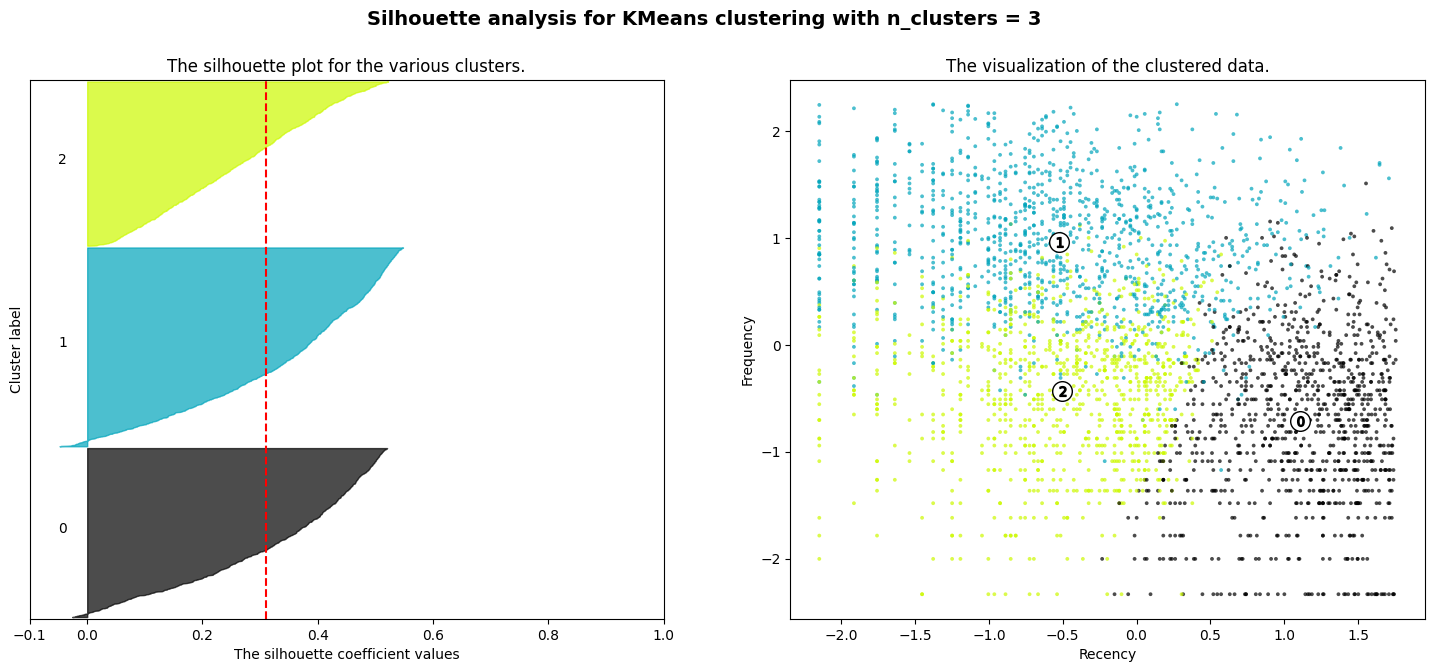

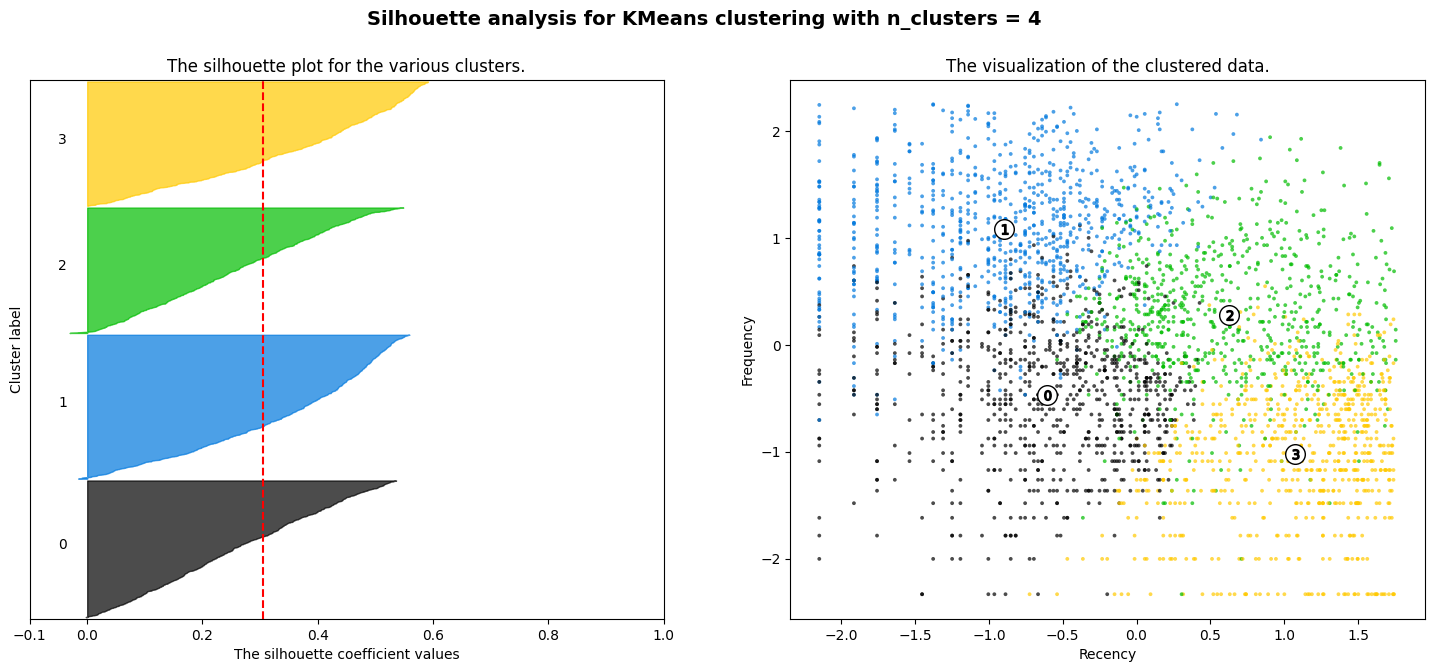

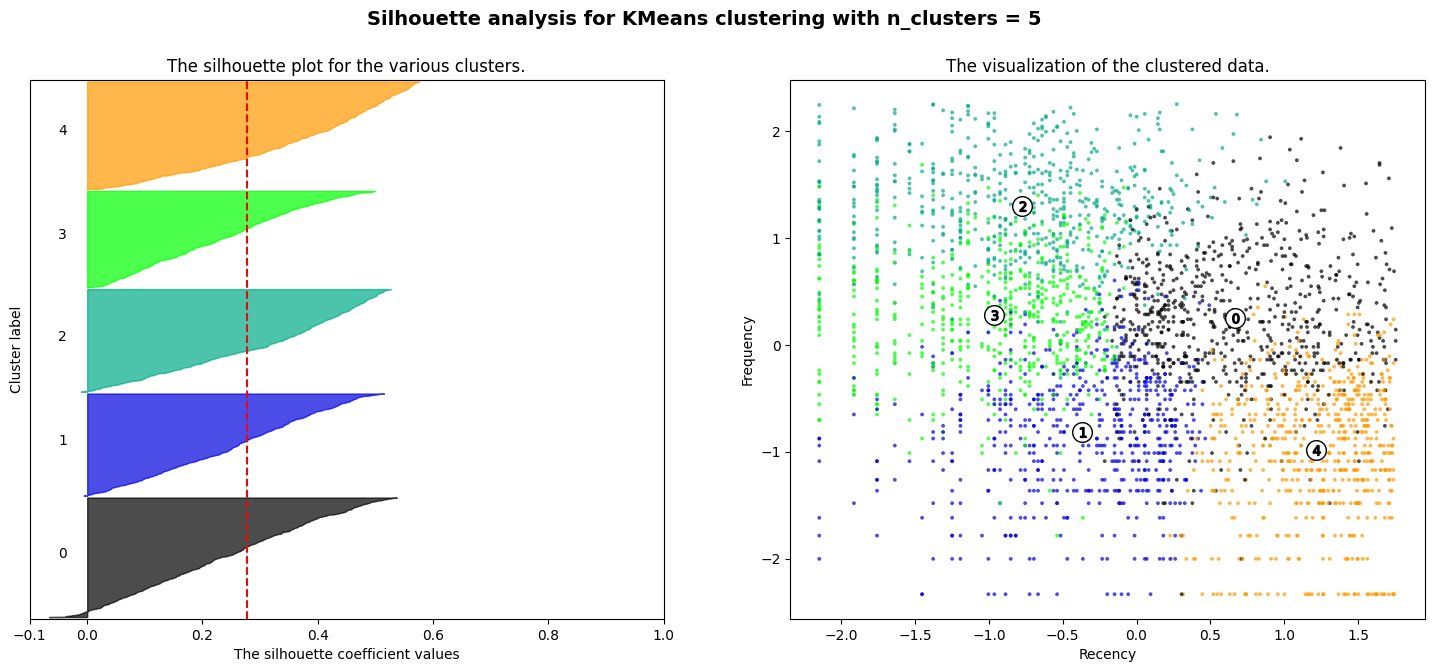

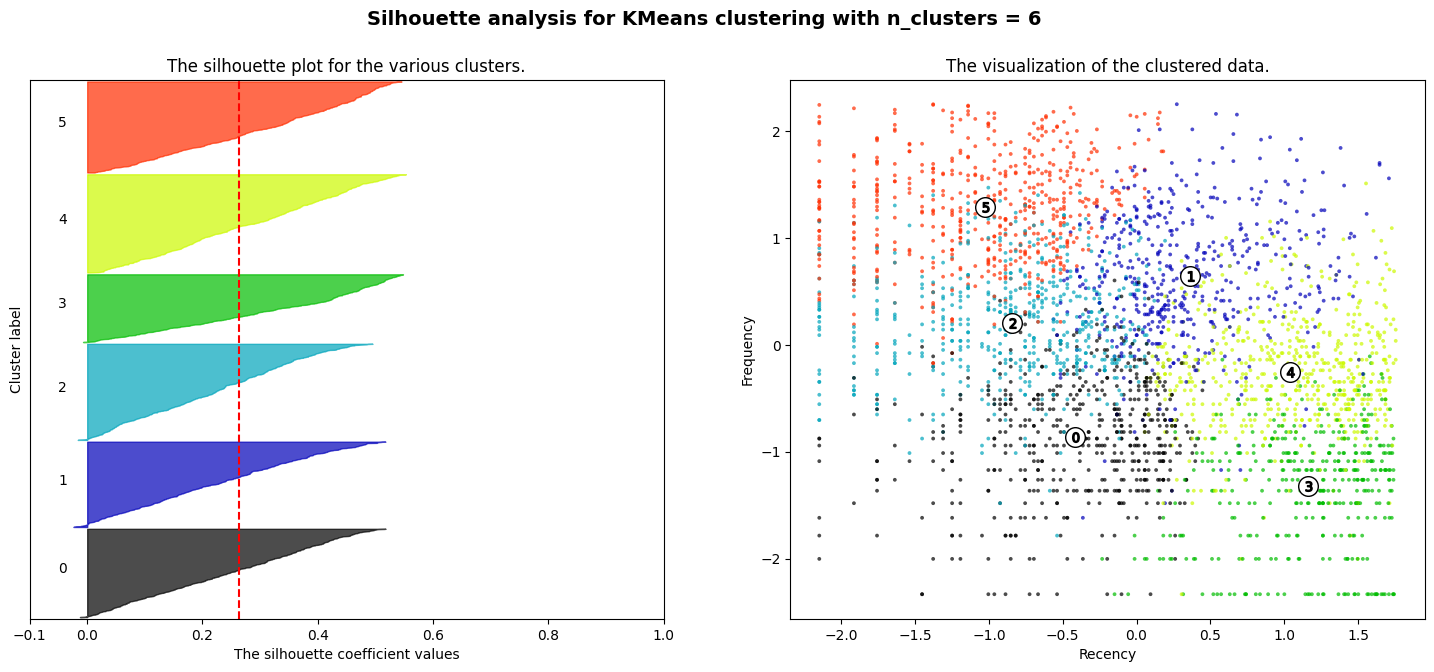

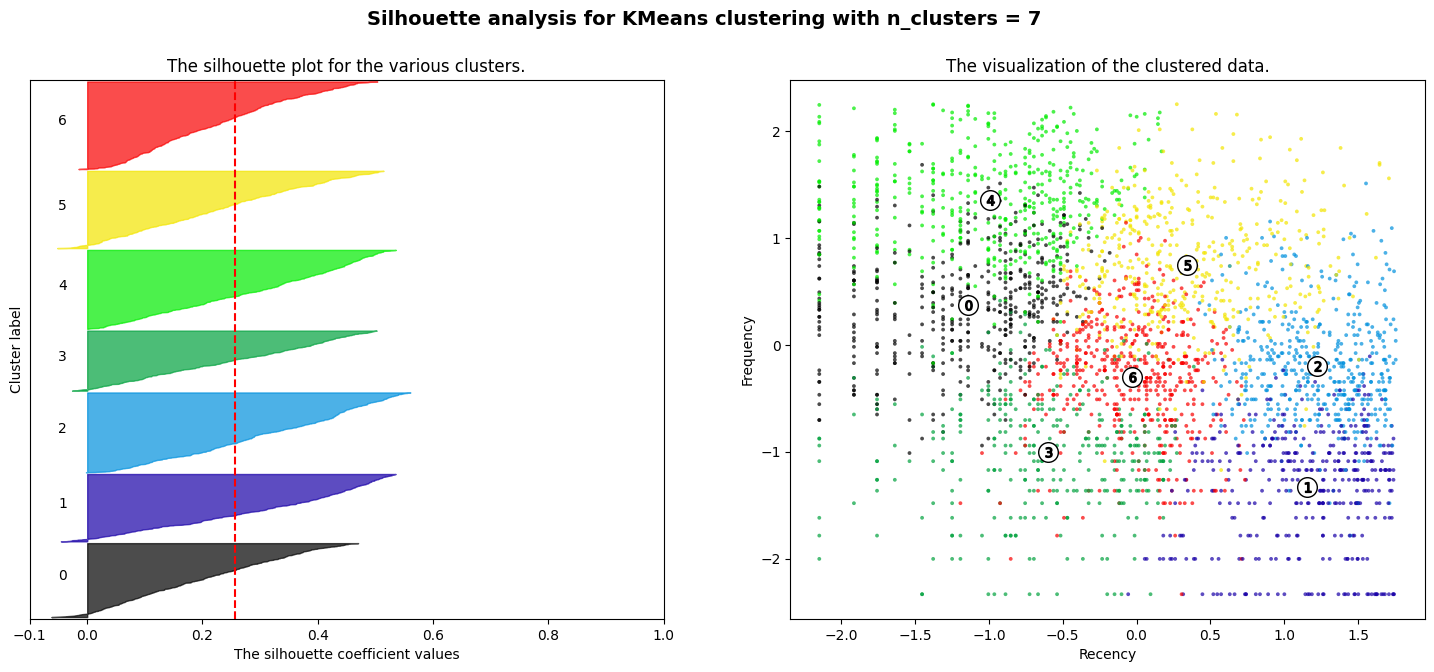

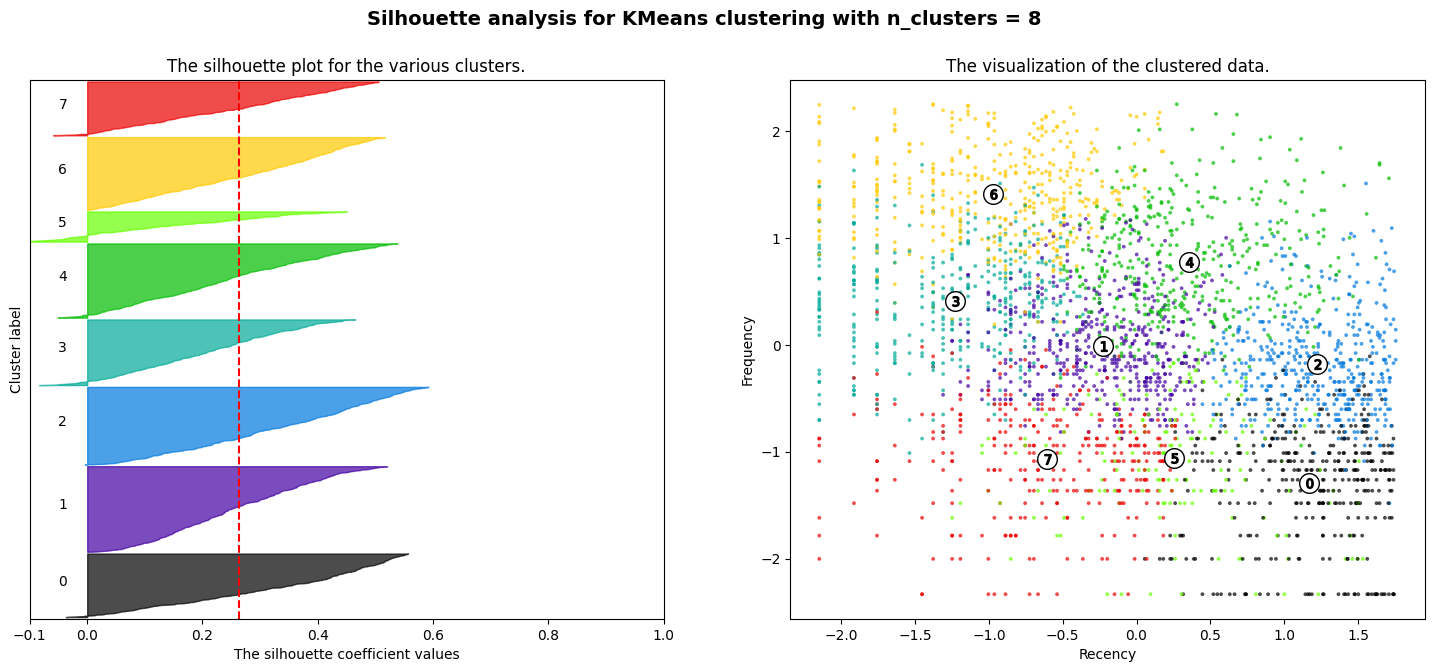

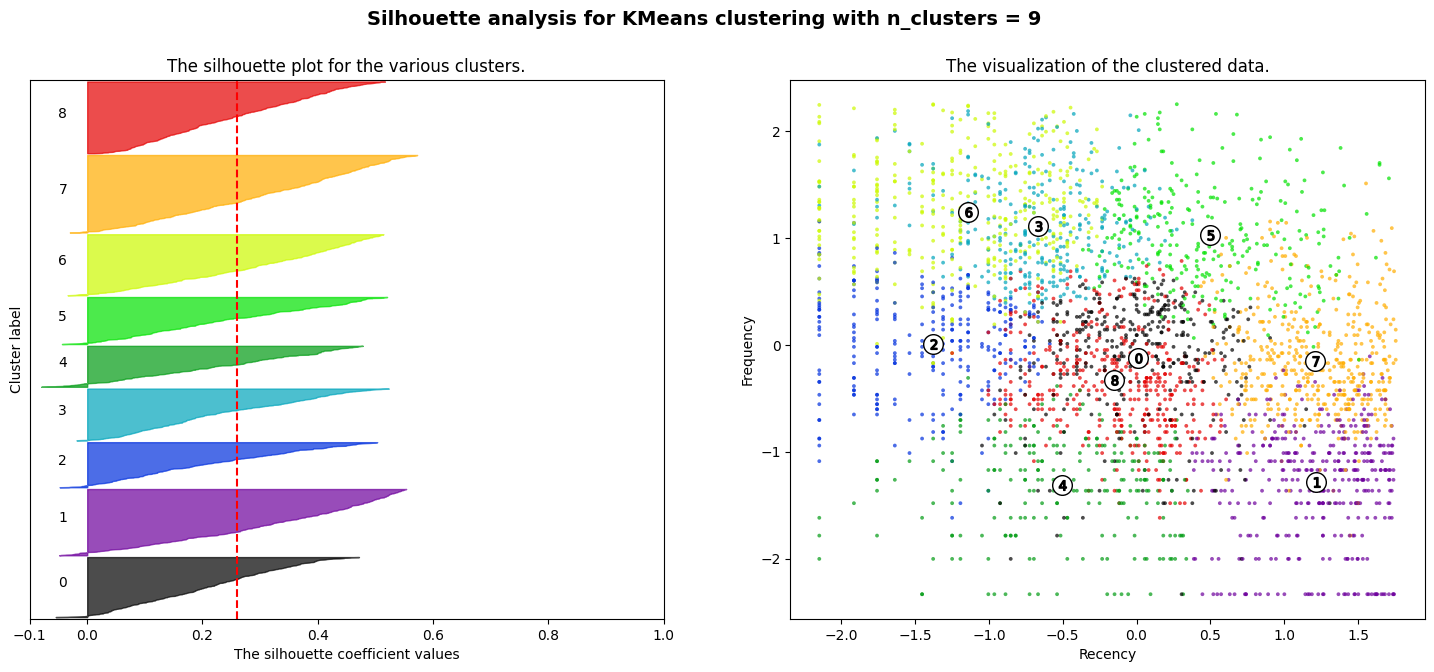

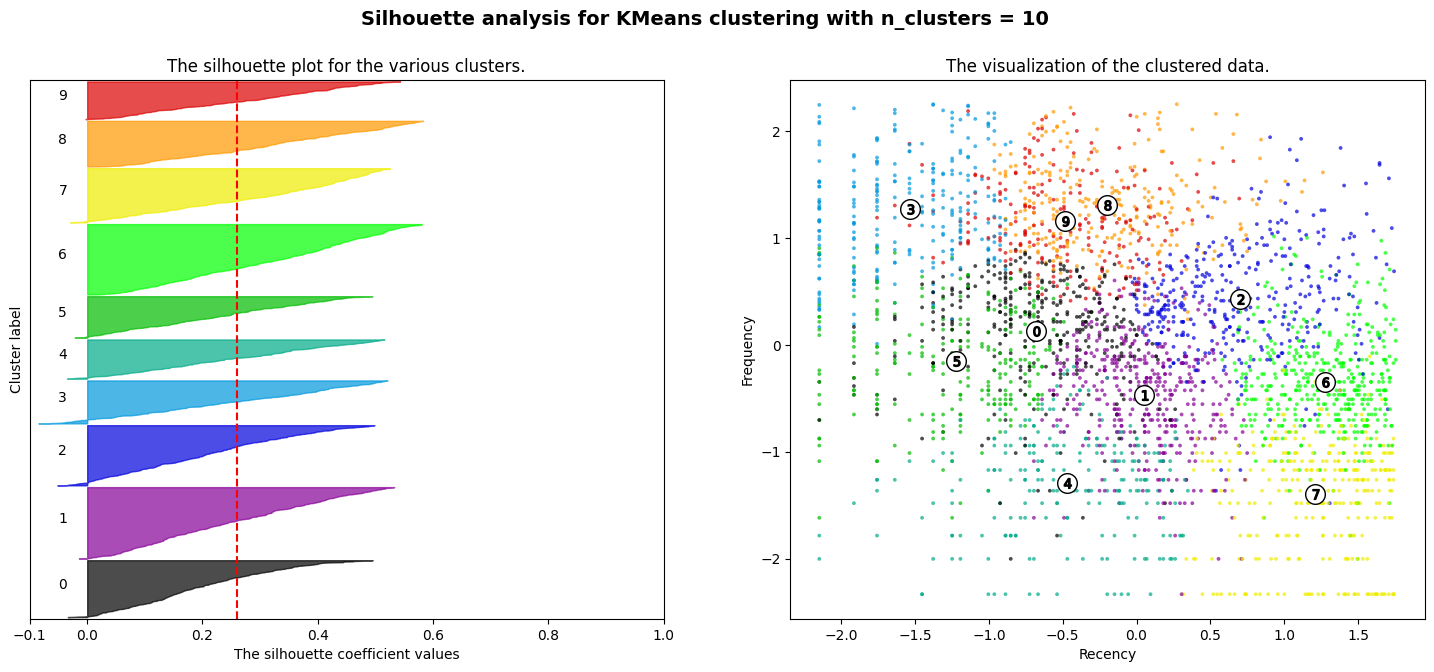

In [123]:

# Extract the features from your DataFrame
X = data[["Recency", "Frequency", "Monetary"]].values

# Define the range of k values you want to explore
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the KMeans clusterer with n_clusters value and a random generator seed for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.2f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Recency")
    ax2.set_ylabel("Frequency")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [71]:
# Init. random centroids
def random_centroids(data,k):
  centroids = []
  for i in range(k):
    centroid = data.apply(lambda x: float(x.sample()))
    centroids.append(centroid)
  return pd.concat(centroids,axis=1)

In [72]:
# Manhattan distances
def get_labels_Manhattan(data, centroids):
    distances = centroids.apply(lambda x: np.abs(data - x).sum(axis=1))
    labels = distances.idxmin(axis=1)
    return labels

In [73]:
# Euclidean Distance (for demo)
def get_labels_euclidean(data,centroids):
  distances = centroids.apply(lambda x:np.sqrt(((data-x)**2).sum(axis=1)))
  return distances.idxmin(axis=1)

In [74]:
# arithmetic arithmeti mean (demo)
def new_centroids_arithmetic(data, labels, k):
    new_centroids = data.groupby(labels).mean().T
    return new_centroids

In [75]:
# geometric mean
def new_centroids_geometric(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [76]:
max_iterations = 100
centroid_count = 2
centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

results = []

while iteration <= max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids

    # Calculate labels using Manhattan distance
    labels_Manhattan = get_labels_Manhattan(data, centroids)
    # Calculate new centroids using arithmetic mean
    centroids_arithmetic = new_centroids_arithmetic(data, labels_Manhattan, centroid_count)
    # Compute silhouette score
    silhouette_manhattan_arithmetic = silhouette_score(data, labels_Manhattan)

    # Calculate labels using Euclidean distance
    labels_euclidean = get_labels_euclidean(data, centroids)
    # Calculate new centroids using arithmetic mean
    centroids_arithmetic = new_centroids_arithmetic(data, labels_euclidean, centroid_count)
    # Compute silhouette score
    silhouette_euclidean_arithmetic = silhouette_score(data, labels_euclidean)

    # Calculate labels using Manhattan distance
    labels_Manhattan = get_labels_Manhattan(data, centroids)
    # Calculate new centroids using geometric mean
    centroids_geometric = new_centroids_geometric(data, labels_Manhattan, centroid_count)
    # Compute silhouette score
    silhouette_manhattan_geometric = silhouette_score(data, labels_Manhattan)

    # Calculate labels using Euclidean distance
    labels_euclidean = get_labels_euclidean(data, centroids)
    # Calculate new centroids using geometric mean
    centroids_geometric = new_centroids_geometric(data, labels_euclidean, centroid_count)
    # Compute silhouette score
    silhouette_euclidean_geometric = silhouette_score(data, labels_euclidean)

    results.append({
        'Distance Metric': 'Manhattan',
        'Mean Type': 'Arithmetic',
        'Silhouette Score': silhouette_manhattan_arithmetic
    })
    results.append({
        'Distance Metric': 'Manhattan',
        'Mean Type': 'Geometric',
        'Silhouette Score': silhouette_manhattan_geometric
    })
    results.append({
        'Distance Metric': 'Euclidean',
        'Mean Type': 'Arithmetic',
        'Silhouette Score': silhouette_euclidean_arithmetic
    })
    results.append({
        'Distance Metric': 'Euclidean',
        'Mean Type': 'Geometric',
        'Silhouette Score': silhouette_euclidean_geometric
    })

    iteration += 1

result_df = pd.DataFrame(results)
result_df

Distance Metric   Mean Type  Silhouette Score
0       Manhattan  Arithmetic          0.321598
1       Manhattan   Geometric          0.321598
2       Euclidean  Arithmetic          0.315601
3       Euclidean   Geometric          0.315601

In [77]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

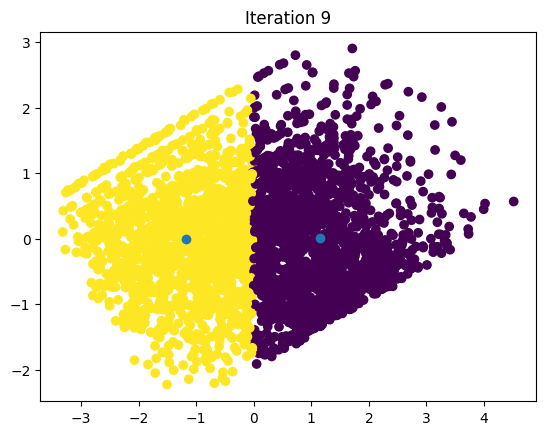

In [78]:
max_iterations = 100
centroid_count = 2

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids


    labels = get_labels_euclidean(data, centroids)    # eculidean or manhatten  mean
    centroids = new_centroids_arithmetic(data, labels, centroid_count)     # geometric or arithmetic mean
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1


In [79]:
silhouette_score(data, labels) * 100

37.69690007541157

In [80]:
kmeans = KMeans(n_clusters=2,max_iter= 100,init='k-means++')
kmeans.fit(data)

KMeans(max_iter=100, n_clusters=2)

In [81]:
def plot_clusters_E(data, labels, centroids):
    pca1 = PCA(n_components=2)
    data_2d1 = pca1.fit_transform(data)
    centroids_2d1 = pca1.transform(centroids)
    clear_output(wait=True)
    plt.scatter(x=data_2d1[:,0], y=data_2d1[:,1], c=labels)
    plt.scatter(x=centroids_2d1[:,0], y=centroids_2d1[:,1])
    plt.show()

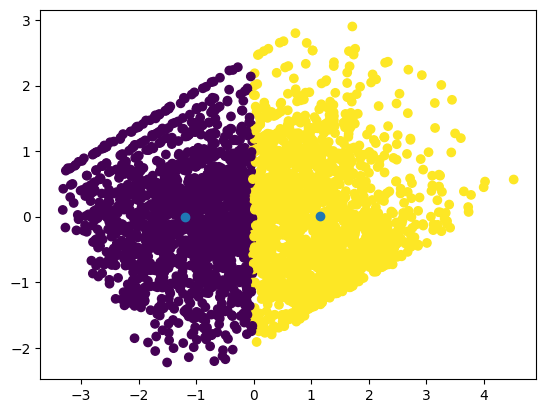

In [82]:
plot_clusters_E(data,kmeans.labels_,kmeans.cluster_centers_)

In [83]:
silhouette_score(data, kmeans.labels_) * 100

37.696145686698614

In [84]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
label_db = dbscan.fit_predict(data)
silhouette_score(data, label_db)

0.32293581604901195

In [85]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='average')
label_hir = agglomerative.fit_predict(data)
silhouette_score(data, label_hir)

0.32112361914532583

In [86]:
# For assigning labels
prd = kmeans.predict(data)

In [87]:
RFM1["Cluster_ID"] = prd

In [88]:
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score  \
4       12820        2         59       942        1        2        2   
5       12821      213          6        93        4        4        4   
6       12822       70         46       949        3        2        2   
7       12823       74          5      1760        3        4        1   
8       12824       59         25       397        3        3        3   

   RFMScore LoyaltyLevel  Cluster_ID  
4         5     Platinum           0  
5        12       Bronze           1  
6         7         Gold           0  
7         8       Silver           1  
8         9       Silver           1

In [89]:
RFM1.groupby("Cluster_ID").mean()

CustomerID     Recency  Frequency     Monetary   R-Score  \
Cluster_ID                                                               
0           15549.731879   44.804362  79.849904  1178.499038  1.887107   
1           15568.853704  138.424074  19.074074   323.691975  3.062346   

             F-Score   M-Score  RFMScore  
Cluster_ID                                
0           1.661963  1.651058  5.200128  
1           3.351235  3.322222  9.735802

In [90]:
RFM1.describe(include="O")

LoyaltyLevel
count          3179
unique            4
top        Platinum
freq            899

<Axes: xlabel='Cluster_ID', ylabel='Recency'>

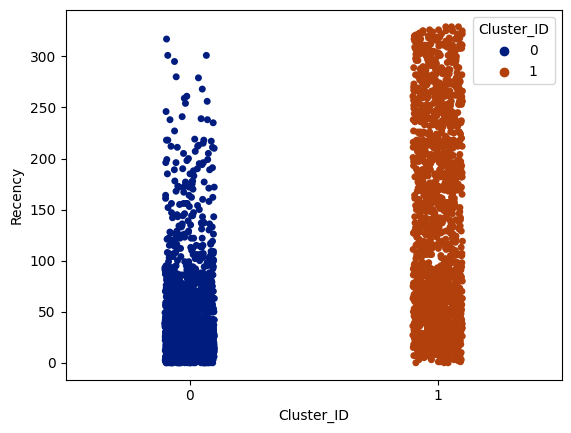

In [91]:
sns.stripplot(x="Cluster_ID",y="Recency",data=RFM1,hue="Cluster_ID", palette="dark")

<Axes: xlabel='Cluster_ID', ylabel='Frequency'>

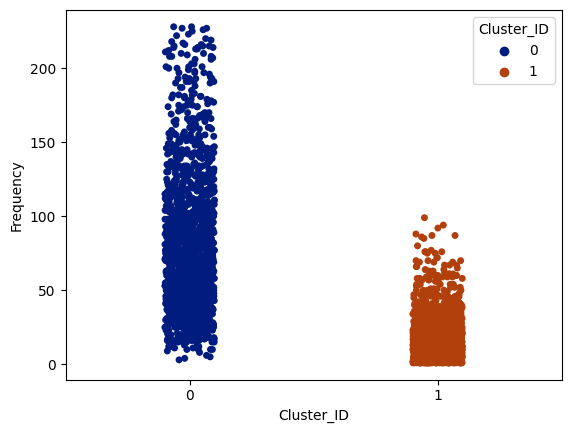

In [92]:
sns.stripplot(x="Cluster_ID",y="Frequency",data=RFM1,hue="Cluster_ID", palette="dark")

<Axes: xlabel='Cluster_ID', ylabel='Monetary'>

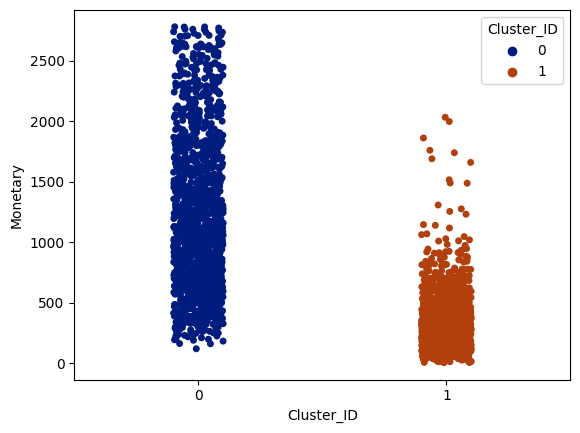

In [93]:
sns.stripplot(x="Cluster_ID",y="Monetary",data=RFM1,hue="Cluster_ID", palette="dark")

In [94]:
RFM1.groupby("Cluster_ID")["LoyaltyLevel"].value_counts()

Cluster_ID  LoyaltyLevel
0           Platinum        899
            Gold            595
            Silver           65
1           Bronze          886
            Silver          647
            Gold             87
Name: LoyaltyLevel, dtype: int64

In [95]:
RFM1[kmeans.labels_ == 1][["CustomerID","LoyaltyLevel"] + features]

CustomerID LoyaltyLevel  Recency  Frequency  Monetary
5          12821       Bronze      213          6        93
7          12823       Silver       74          5      1760
8          12824       Silver       59         25       397
14         12831       Bronze      261          9       215
15         12832       Silver       31         27       383
...          ...          ...      ...        ...       ...
3913       18277       Bronze       57          8       110
3914       18278       Bronze       73          9       174
3915       18280       Bronze      277         10       181
3916       18281       Bronze      180          7        81
3917       18282       Silver        7         12       178

[1620 rows x 5 columns]

In [138]:
c0_gold = pd.DataFrame(RFM1[(kmeans.labels_ == 0) & (RFM1['LoyaltyLevel'] == 'Gold')])
c1_gold = pd.DataFrame(RFM1[(kmeans.labels_ == 1) & (RFM1['LoyaltyLevel'] == 'Gold')])
c0_silver = pd.DataFrame(RFM1[(kmeans.labels_ == 0) & (RFM1['LoyaltyLevel'] == 'Silver')])
c1_silver = pd.DataFrame(RFM1[(kmeans.labels_ == 1) & (RFM1['LoyaltyLevel'] == 'Silver')])

In [144]:
c0_gold.describe().T

count          mean          std      min      25%      50%  \
CustomerID  595.0  15687.028571  1556.020646  12822.0  14343.0  15809.0   
Recency     595.0     64.684034    57.703127      0.0     24.0     50.0   
Frequency   595.0     52.971429    30.712924      3.0     32.5     46.0   
Monetary    595.0    833.438655   450.706816    120.0    528.5    712.0   
R-Score     595.0      2.310924     0.924306      1.0      2.0      2.0   
F-Score     595.0      2.115966     0.741958      1.0      2.0      2.0   
M-Score     595.0      2.043697     0.766363      1.0      2.0      2.0   
RFMScore    595.0      6.470588     0.499554      6.0      6.0      6.0   
Cluster_ID  595.0      0.000000     0.000000      0.0      0.0      0.0   

                75%      max  
CustomerID  16994.0  18265.0  
Recency        85.0    317.0  
Frequency      63.0    192.0  
Monetary     1030.5   2643.0  
R-Score         3.0      4.0  
F-Score         3.0      4.0  
M-Score         3.0      4.0  
RFMScore        7.0      7.0  
Cluster_ID      0.0      0.0

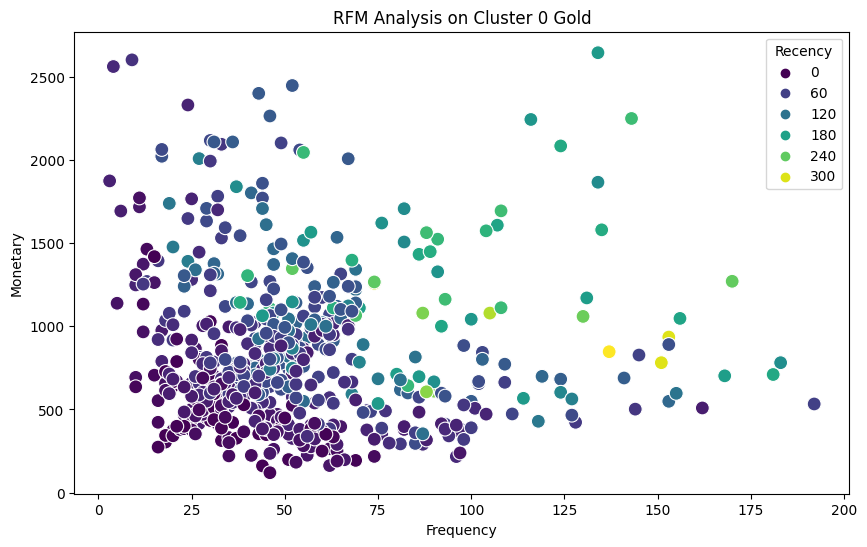

In [165]:
# Create the scatter plot with hue differentiation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=c0_gold, x='Frequency', y='Monetary', hue='Recency', palette='viridis', s=100)

# Add labels and legend
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 0 Gold')
plt.legend(title='Recency')

# Show the plot
plt.show()

In [145]:
c1_gold.describe().T

count          mean          std      min      25%      50%  \
CustomerID   87.0  15735.494253  1712.285803  12953.0  14038.0  15699.0   
Recency      87.0     64.114943    75.645351      4.0     17.0     22.0   
Frequency    87.0     33.103448    18.291588      2.0     19.5     34.0   
Monetary     87.0    463.137931   220.213911    132.0    305.5    382.0   
R-Score      87.0      1.862069     1.002003      1.0      1.0      1.0   
F-Score      87.0      2.448276     0.711347      1.0      2.0      2.0   
M-Score      87.0      2.678161     0.739174      1.0      2.0      3.0   
RFMScore     87.0      6.988506     0.107211      6.0      7.0      7.0   
Cluster_ID   87.0      1.000000     0.000000      1.0      1.0      1.0   

                75%      max  
CustomerID  17425.5  18232.0  
Recency        95.0    322.0  
Frequency      40.0     94.0  
Monetary      608.0   1232.0  
R-Score         3.0      4.0  
F-Score         3.0      4.0  
M-Score         3.0      4.0  
RFMScore        7.0      7.0  
Cluster_ID      1.0      1.0

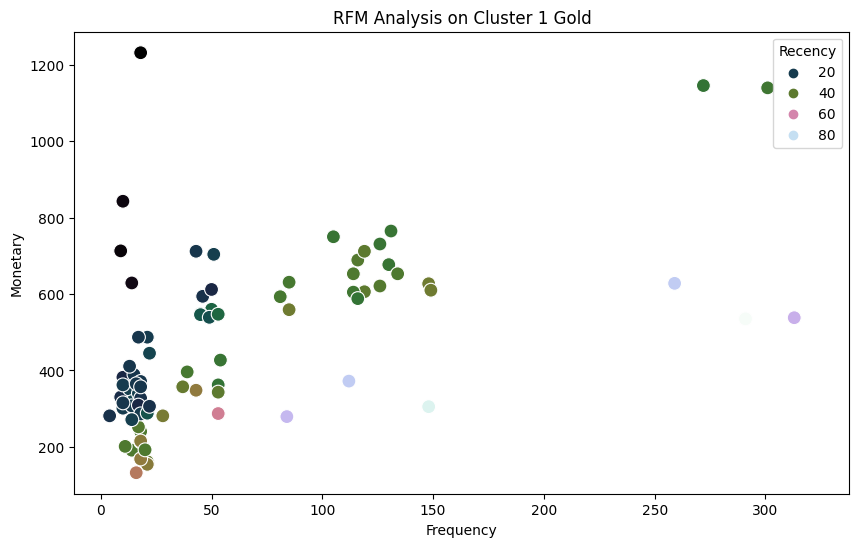

In [166]:
# Create the scatter plot with hue differentiation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=c1_gold, x='Recency', y='Monetary', hue='Frequency', palette='cubehelix', s=100)

# Add labels and legend
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 1 Gold')
plt.legend(title='Recency')

# Show the plot
plt.show()

In [156]:
c0_silver.describe().T

count          mean          std      min      25%      50%  \
CustomerID   65.0  15233.569231  1450.078575  12924.0  13763.0  15076.0   
Recency      65.0    108.492308    77.271260      0.0     35.0     79.0   
Frequency    65.0     43.015385    22.836027      8.0     28.0     33.0   
Monetary     65.0    782.861538   416.222667    210.0    482.0    834.0   
R-Score      65.0      3.030769     0.918035      1.0      2.0      3.0   
F-Score      65.0      2.553846     0.729528      1.0      2.0      3.0   
M-Score      65.0      2.415385     0.768365      1.0      2.0      2.0   
RFMScore     65.0      8.000000     0.000000      8.0      8.0      8.0   
Cluster_ID   65.0      0.000000     0.000000      0.0      0.0      0.0   

                75%      max  
CustomerID  16551.0  18205.0  
Recency       177.0    279.0  
Frequency      57.0    132.0  
Monetary      962.0   2207.0  
R-Score         4.0      4.0  
F-Score         3.0      4.0  
M-Score         3.0      4.0  
RFMScore        8.0      8.0  
Cluster_ID      0.0      0.0

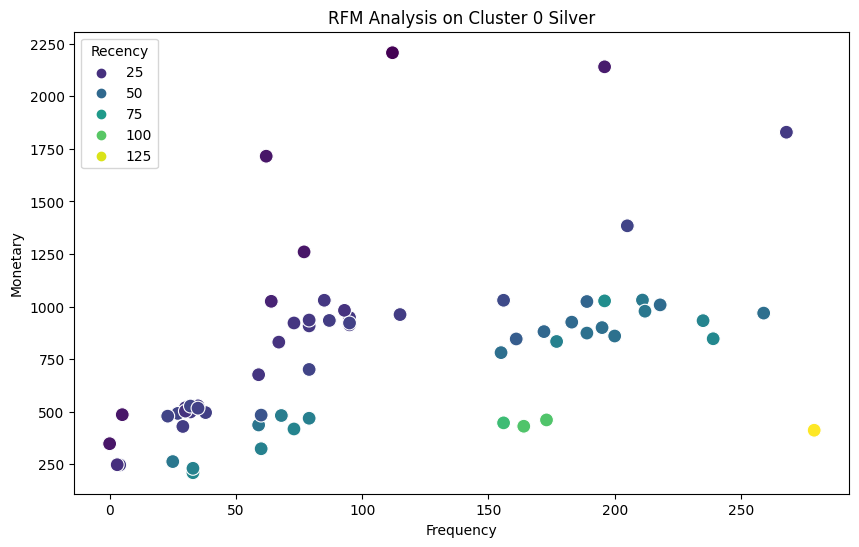

In [167]:
# Create the scatter plot with hue differentiation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=c0_silver, x='Recency', y='Monetary', hue='Frequency', palette='viridis', s=100)

# Add labels and legend
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 0 Silver')
plt.legend(title='Recency')

# Show the plot
plt.show()

In [157]:
c1_silver.describe().T

count          mean          std      min      25%      50%  \
CustomerID  647.0  15564.741886  1559.345727  12823.0  14300.5  15551.0   
Recency     647.0     93.069552    82.547855      0.0     31.0     64.0   
Frequency   647.0     25.539413    16.773152      1.0     14.0     23.0   
Monetary    647.0    423.530139   271.148175     30.0    250.0    371.0   
R-Score     647.0      2.578053     1.013690      1.0      2.0      3.0   
F-Score     647.0      3.023184     0.763579      1.0      3.0      3.0   
M-Score     647.0      2.979907     0.789579      1.0      2.0      3.0   
RFMScore    647.0      8.581144     0.493753      8.0      8.0      9.0   
Cluster_ID  647.0      1.000000     0.000000      1.0      1.0      1.0   

                75%      max  
CustomerID  16853.5  18282.0  
Recency       132.5    329.0  
Frequency      33.0     99.0  
Monetary      543.5   2033.0  
R-Score         3.0      4.0  
F-Score         4.0      4.0  
M-Score         4.0      4.0  
RFMScore        9.0      9.0  
Cluster_ID      1.0      1.0

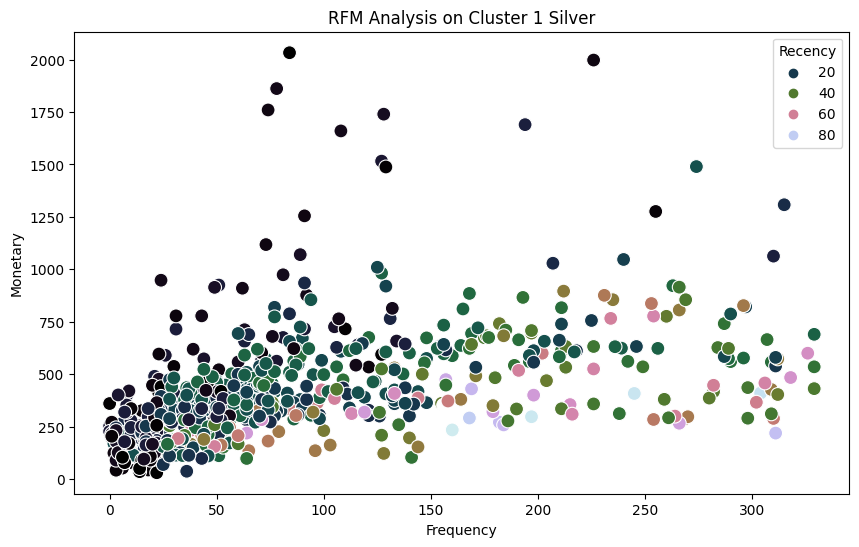

In [168]:
# Create the scatter plot with hue differentiation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=c1_silver, x='Recency', y='Monetary', hue='Frequency', palette='cubehelix', s=100)

# Add labels and legend
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 1 Silver')
plt.legend(title='Recency')

# Show the plot
plt.show()

In [96]:
crt = RFM1.copy()

In [97]:
x = crt.iloc[:,1:4]
y=crt.iloc[:,-1]

In [98]:
x.head()

Recency  Frequency  Monetary
4        2         59       942
5      213          6        93
6       70         46       949
7       74          5      1760
8       59         25       397

In [99]:
y.head()

4    0
5    1
6    0
7    1
8    1
Name: Cluster_ID, dtype: int32

In [100]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [101]:
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_test = std.fit_transform(x_test)

In [102]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
prd = lr.predict(x_test)

In [103]:
prd

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,

In [104]:
model_accuracy = accuracy_score(prd,y_test)
model_accuracy

0.9371069182389937

In [105]:
ly = crt.iloc[:,-2]

In [106]:
lx_train,lx_test,ly_train,ly_test = train_test_split(x,ly,test_size=0.2, random_state=42)

In [107]:
lx_train = std.fit_transform(lx_train)
lx_test = std.fit_transform(lx_test)

In [108]:
ran_obj = RandomForestClassifier()
ran_obj.fit(lx_train,ly_train)
ran_obj.score(lx_test,ly_test)

0.8930817610062893

In [109]:
nb_classifier = GaussianNB()
nb_classifier.fit(lx_train, ly_train)
print("Naive Bayes classifier accuracy")
nb_classifier.score(lx_test,ly_test)

Naive Bayes classifier accuracy


0.6981132075471698

In [110]:
dt_obj = DecisionTreeClassifier()
dt_obj.fit(lx_train,ly_train)
print("Decision Tree Classifier accuracy")
dt_obj.score(lx_test,ly_test)

Decision Tree Classifier accuracy


0.8867924528301887

In [111]:
svc_obj = svm.SVC()
svc_obj.fit(lx_train,ly_train)
print("SVC model accuracy ")
svc_obj.score(lx_test,ly_test)

SVC model accuracy 


0.8522012578616353

In [113]:
def get_customer_info(customer_id):
    customer_data = RFM1[RFM1['CustomerID'] == customer_id]
    if not customer_data.empty:
        loyalty_level = customer_data['LoyaltyLevel'].values[0]
        recency = customer_data['Recency'].values[0]
        frequency = customer_data['Frequency'].values[0]
        monetary = customer_data['Monetary'].values[0]
        return loyalty_level, recency, frequency, monetary
    else:
        return None


input_customer_id = int(input("Enter Customer ID: "))
result = get_customer_info(input_customer_id)

if result:
    loyalty_level, recency, frequency, monetary = result
    print(f'Customer ID: {input_customer_id}')
    print(f'Loyalty Level: {loyalty_level}')
    print(f'Recency: {recency}')
    print(f'Frequency: {frequency}')
    print(f'Monetary: {monetary}')
else:
    print(f'Customer ID {input_customer_id} not found.')

Enter Customer ID: 18055
Customer ID 18055 not found.


In [169]:
new_data = (1,12,1000)

input_array = np.asarray(new_data)

data_reshape = input_array.reshape(1,-1)

std_input = std.transform(data_reshape)

cluster = lr.predict(std_input)

loyalty = ran_obj.predict(std_input)

if (cluster[0]==0):
  print("Customer belong to Cluster 0")
else:
  print("Customer belong to Cluster 1")

print("Loyalty level :", loyalty[0] )

Customer belong to Cluster 0
Loyalty level : Gold


In [114]:
merge = pd.merge(df[['CustomerID', 'Description', 'Quantity']], RFM1[['CustomerID',"Cluster_ID"]], on='CustomerID', how='inner')
merge.rename(columns={'Description': 'Product'}, inplace=True)
merge.head()

CustomerID                          Product  Quantity  Cluster_ID
0       13748  PAPER CHAIN KIT 50'S CHRISTMAS         80           0
1       13748        BISCUIT TIN VINTAGE GREEN         2           0
2       13748     ROUND CAKE TIN VINTAGE GREEN         2           0
3       13748  3 TIER CAKE TIN GREEN AND CREAM         2           0
4       13748         REGENCY CAKESTAND 3 TIER         2           0

In [115]:
recommendations_by_cluster = {}

for cluster_id in range(2):
    cluster_df = merge[merge['Cluster_ID'] == cluster_id]
    product_cluster = cluster_df.groupby("Product")["Quantity"].sum().reset_index()
    sorted_products = product_cluster.sort_values(by="Quantity", ascending=False)
    top_5_products = sorted_products.head(5)
    recommendations_by_cluster[cluster_id] = top_5_products

for cluster_id in range(2):
    cluster_recommendations = recommendations_by_cluster.get(cluster_id)
    print(f"Top 5 recommendations for Cluster {cluster_id}:\n{cluster_recommendations}\n")

Top 5 recommendations for Cluster 0:
                                 Product  Quantity
3467   WORLD WAR 2 GLIDERS ASSTD DESIGNS     12568
2961         SMALL CHINESE STYLE SCISSOR      9263
200        ASSORTED COLOUR BIRD ORNAMENT      9027
3385  WHITE HANGING HEART T-LIGHT HOLDER      6510
1596             JUMBO BAG RED RETROSPOT      6190

Top 5 recommendations for Cluster 1:
                                  Product  Quantity
913   ESSENTIAL BALM 3.5g TIN IN ENVELOPE      5586
417                   BROCADE RING PURSE       4890
182             ASSORTED COLOURS SILK FAN      4124
2566          SMALL CHINESE STYLE SCISSOR      3698
2942   WHITE HANGING HEART T-LIGHT HOLDER      2765

